<H1>Uni-variate prediction using difference in flows (Rate of change)</h1>

In [199]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.io as pio
import tensorflow as tf
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import *
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam


<h2>Importing data</h2>

In [200]:
directory_list = [
    os.path.join('..', 'Inputs_outputs_excels', 'wsv_rhine_export_with_outliers_balanced.xlsx'),
    os.path.join('..', 'Inputs_outputs_excels', 'wsv_rhine_export - pseudo_huber_29_4_2024.xlsx'),
    os.path.join('..', 'Inputs_outputs_excels', 'wsv_rhine_export_outliers_pseudo_huber.xlsx'),
    os.path.join('..', 'Inputs_outputs_excels', 'rate_of_change_df.xlsx')
]

df=pd.read_excel(directory_list[2])
df.index=pd.to_datetime(df['Date'],format='%d.%m.%Y %H:%M:%S')
df=df[1:]   #Not selecting the first row because it has zeros
y_val = df[-366:]
df = df[1:-365]
df_roc=pd.read_excel(directory_list[3])
df_roc=df_roc[1:]   #Not selecting the first row because it has zeros
X_val = df_roc[-366:]    #validation dataset
df_roc = df_roc[1:-365]
df_roc.index=pd.to_datetime(df_roc['Date'],format='%d.%m.%Y %H:%M:%S')

<h3>Input data</h3>

In [201]:
features_for_input=['Rate of change ANDER/flow.bc',
                'Rate of change BONN/flow.obs',
                 'Rate of change KOELN/flow.obs',
                 'Rate of change DUESS/flow.obs',
                 'Rate of change DUISB/flow.obs',
                 'Rate of change WESEL/flow.obs',
                 'Rate of change REES/flow.obs',
                 'Rate of change EMMER/flow.obs']
df_input=df_roc[features_for_input]
X_val= X_val[features_for_input]

<h2>Preprocessing data </h2>

<h3>Creating the label dataframe</h3>

In [202]:
output_attributes=['BONN/flow.bc',
                    'KOELN/flow.bc',
                    'DUESS/flow.bc',
                    'DUISB/flow.bc',
                    'WESEL/flow.bc',
                    'REES/flow.bc',
                    'EMMER/flow.bc']
df_output=df[output_attributes]
y_val=y_val[output_attributes]

<h2>Splitting data into test, validation and train with window size</h2>

In [203]:
feature_label1= 5
feature_label2= 6
X=df_input.iloc[:,feature_label1]    #Since univariate, choosing only one parameter instead of the whole dataframe for model fitting
y=df_output.iloc[:,feature_label2]
X_val=X_val.iloc[:,feature_label1]
y_val= y_val.iloc[:,feature_label2]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=42)


<h3> Scaling the input and target data</h3>

In [204]:
scaler_x=MinMaxScaler(feature_range=(-1,1))
scaler_y=MinMaxScaler(feature_range=(-1,1))

X_train_reshaped = X_train.values.reshape(-1, 1)
X_test_reshaped = X_test.values.reshape(-1, 1)
X_val_reshaped = X_val.values.reshape(-1, 1)

y_train_reshaped = y_train.values.reshape(-1, 1)
y_test_reshaped = y_test.values.reshape(-1, 1)
y_val_reshaped = y_val.values.reshape(-1, 1)

X_train_scaled = scaler_x.fit_transform(X_train_reshaped)
X_test_scaled = scaler_x.transform(X_test_reshaped)
X_val_scaled = scaler_x.transform(X_val_reshaped)

y_train_scaled = scaler_y.fit_transform(y_train_reshaped)
y_test_scaled = scaler_y.transform(y_test_reshaped)
y_val_scaled = scaler_y.transform(y_val_reshaped)


X_train_scaled.shape, y_train_scaled.shape, X_test_scaled.shape, y_test_scaled.shape
#X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, y_test_scaled

((2300, 1), (2300, 1), (986, 1), (986, 1))

<h1>Regressor</h1>

In [205]:
base_regressor = GradientBoostingRegressor()

<h2>Fitting the model</h2>

In [206]:
base_regressor.fit(X_train_scaled,y_train_scaled.ravel())

GradientBoostingRegressor()

<h2>Predicting and MAE</h2>

In [207]:
predictions = base_regressor.predict(X_test_scaled)
predictions_original_scale = scaler_y.inverse_transform(predictions.reshape(-1, 1))

mae_regressor=mean_absolute_error(y_test, predictions_original_scale)
mse_regressor=mean_squared_error(y_test, predictions_original_scale)
mae_regressor, mse_regressor

(11.026885980538035, 259.31265844542753)

<h2>Output visualization</h2>

In [208]:
data = {
    'Date': df_output.index[-len(predictions):],
    'SISO GBR': predictions_original_scale.flatten(),
    'DA': y_test
}
df_plot = pd.DataFrame(data)

fig = px.scatter(df_plot, x='Date', y=['SISO GBR', 'DA'],
                 labels={'value': 'Mass balance correction (m³/s)'},
                 title='Mass balance correction comparison for ' + df_output.columns[feature_label],
                 color_discrete_sequence=['blue', 'orange'])
fig.update_traces(marker={'size': 2},
                  #line=dict(dash='dash'),
                  mode='lines+markers')
fig.update_layout(width=1000, height=600)
fig.show()
#filepath=r'C:\Users\sujan.maharjan\Desktop\KISTERS\figures\regressor_Emmer.html'
#fig.write_html(filepath)

<h2>Validation</H2>

In [209]:
predictions_val = base_regressor.predict(X_val_scaled)
validations_original_scale = scaler_y.inverse_transform(predictions_val.reshape(-1, 1))

In [210]:
data = {
    'Date': y_val.index[-len(predictions_val):],
    'SISO GBR': validations_original_scale.flatten(),
    'DA': y_val
}
df_plot = pd.DataFrame(data)

fig = px.scatter(df_plot, x='Date', y=['SISO GBR', 'DA'],
                 labels={'value': 'Mass balance correction (m³/s)'},
                 title='SISO GBR with ROC input for ' + df_output.columns[feature_label],
                 color_discrete_sequence=['blue', 'orange'])
fig.update_traces(marker={'size': 2},
                  mode='lines+markers')
fig.update_layout(width=900, height=600,
                    legend={
                        'x': 0.85,  # x position
                        'y': 0.01,  # y position
                        'bgcolor': 'rgba(255, 255, 255, 0.5)',  # semi-transparent background
                        'bordercolor': 'Black',
                        'borderwidth': 1
                    })
fig.show()
#filepath=r'C:\Users\sujan.maharjan\Desktop\KISTERS\figures\regressor_Emmer.html'
#fig.write_html(filepath)

<h2>Validation</h2>

<h1> Feed forward neural network </h1>

<h2> Define the neural network model</h2>

In [211]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(y_train_scaled.shape[1])  # Output layer
])

c:\Projects\venv0.7\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



<h2> Compile the model </h2>

In [212]:
model.compile(optimizer=Adam(learning_rate=0.00001), loss='mean_squared_error',metrics=['mean_absolute_error'])

<h2> Model fit </h2>

In [213]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train_scaled, y_train_scaled, epochs=200, validation_split=0.3)

Epoch 1/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1441 - mean_absolute_error: 0.3559 - val_loss: 0.1391 - val_mean_absolute_error: 0.3535
Epoch 2/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1373 - mean_absolute_error: 0.3482 - val_loss: 0.1360 - val_mean_absolute_error: 0.3493
Epoch 3/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1377 - mean_absolute_error: 0.3478 - val_loss: 0.1329 - val_mean_absolute_error: 0.3452
Epoch 4/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1393 - mean_absolute_error: 0.3489 - val_loss: 0.1299 - val_mean_absolute_error: 0.3411
Epoch 5/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1273 - mean_absolute_error: 0.3335 - val_loss: 0.1270 - val_mean_absolute_error: 0.3370
Epoch 6/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1322 - mean_absolute_error: 0.3389 - val_loss: 0.1241 - val_mean_absolute_error: 0.3329
Epoch 7/200
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1264 - mean_absolute_error: 0.3332 - val_los

<h2>Model evaluation </h2>

In [214]:
predictions = model.predict(X_test_scaled)
predictions_rescaled = scaler_y.inverse_transform(predictions)
mae_FFNN=mean_absolute_error(y_test, predictions_rescaled)
mse_FFNN=mean_squared_error(y_test, predictions_rescaled)
mae_FFNN, mse_FFNN


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


(10.894454116330428, 257.4537026271456)

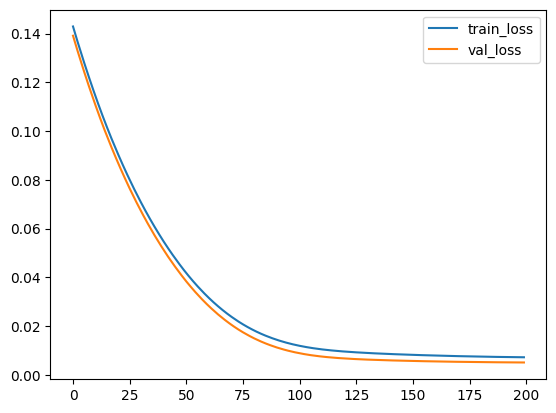

In [215]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

<h2>Output visualization</h2>

In [216]:
data = {
    'Date': df_output.index[-len(predictions):],
    'Predictions': predictions_rescaled[:, 0],
    'Simulated MBC': y_test
}
df_plot = pd.DataFrame(data)

fig = px.scatter(df_plot, x='Date', y=['Predictions', 'Simulated MBC'],
                 labels={'value': 'Mass balance correction (m³/s)'},
                 title='Predictions vs Actual for ' + df_output.columns[6],
                 color_discrete_sequence=['blue', 'orange'])
fig.update_traces(marker={'size': 2},
                  #line=dict(dash='dash'),
                  mode='lines+markers')

fig.show()
#filepath=r'C:\Users\sujan.maharjan\Desktop\KISTERS\figures\FFNN_Emmer.html'
#fig.write_html(filepath)


<h2>Validation</h2>

In [217]:
predictions_val = model.predict(X_val_scaled)
predictions_rescaled_val = scaler_y.inverse_transform(predictions_val)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [218]:
data = {
    'Date': y_val.index,
    'SISO FFNN': predictions_rescaled_val.flatten(),
    'DA': y_val
}
df_plot = pd.DataFrame(data)

fig = px.scatter(df_plot, x='Date', y=['SISO FFNN', 'DA'],
                 labels={'value': 'Mass balance correction (m³/s)'},
                 title='SISO FFNN with ROC input for ' + df_output.columns[feature_label],
                 color_discrete_sequence=['blue', 'orange'])
fig.update_traces(marker={'size': 2},
                  mode='lines+markers')
fig.update_layout(width=900, height=600,
                    legend={
                        'x': 0.85,  # x position
                        'y': 0.01,  # y position
                        'bgcolor': 'rgba(255, 255, 255, 0.5)',  # semi-transparent background
                        'bordercolor': 'Black',
                        'borderwidth': 1
                    })
fig.show()
#filepath=r'C:\Users\sujan.maharjan\Desktop\KISTERS\figures\regressor_Emmer.html'
#fig.write_html(filepath)